In [1]:
# !pip install xgboost 1234

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

#### 1. 데이터 생성

In [3]:
salary = pd.read_csv('salary.csv')

np.shape(salary) # 32561행 15열

(32561, 15)

#### 2. 데이터 확인 (5개)

In [4]:
salary[:5]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### 3. 변수 타입 확인

In [5]:
salary.dtypes
# int64: 수치형, object: 범주형

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
salary            object
dtype: object

#### 4. 중복 데이터 확인 및 제거

In [6]:
np.sum(salary.duplicated()) # 중복 데이터 24개

24

In [7]:
salary = salary.drop_duplicates() # 중복 데이터 제거
print(np.shape(salary)) # 32537행 15열

(32537, 15)


#### 5. 범주형 변수의 범주 및 빈도수 확인

##### 5-1. workclass 변수

>Private(일반 회사원)  
Self-emp-not-inc(비법인 자영업자)  
Self-emp-inc(법인 자영업자)  
Federal-gov(연방정부 공무원)  
Local-gov(지방정부 공무원)  
State-gov(주립정부 공무원)  
Never-worked(일 경험 없음)  
Without-pay(무보수)  
?(결측치)  

In [8]:
print(salary['workclass'].value_counts()) # 결측치 1836개

workclass
Private             22673
Self-emp-not-inc     2540
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64


##### 5-2. education 변수

>Doctorate(박사 학위)  
Masters(석사 학위)  
Bachelors(4년제 학사)  
Some-college(전문대)  
Assoc-voc(준학사 학위)  
Assoc-acdm(아카데믹 어소시에이트)  
Prof-school(전문 학교)  
HS-grad(고졸)  
9th(9학년)  
7th-8th(7학년-8학년)  
5th-6th(5학년-6학년)  
1st-4th(1학년-4학년)  
Preschool(유치원)  

In [9]:
salary['education'].value_counts()

education
HS-grad         10494
Some-college     7282
Bachelors        5353
Masters          1722
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           645
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           332
1st-4th           166
Preschool          50
Name: count, dtype: int64

In [10]:
salary['education-num'].value_counts()
# 확인 결과 학력이 낮은 순서로 1, 2, ..., 16까지 라벨 인코딩 되어 있음

education-num
9     10494
10     7282
13     5353
14     1722
11     1382
7      1175
12     1067
6       933
4       645
15      576
5       514
8       433
16      413
3       332
2       166
1        50
Name: count, dtype: int64

##### 5-3. marital-status 변수

>Divorced(이혼)  
Married-AF-spouse(군인 배우자와 결혼)  
Married-civ-spouse(민간인 배우자와 결혼)  
Married-spouse-absent(직장 등의 이유로 별거)  
Never-married(미혼)  
Separated(이혼 등의 이유로 별거)  
Widowed(미망인)  

In [11]:
print(salary['marital-status'].value_counts())

marital-status
Married-civ-spouse       14970
Never-married            10667
Divorced                  4441
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64


##### 5-4. occupation 변수

>Prof-specialty(전문직)  
Craft-repair(수리공)  
Exec-managerial(경영진)  
Adm-clerical(사무/관리직)  
Sales(판매업)  
Other-service(기타 서비스업)  
Machine-op-inspct(기계 검사 직종)  
Transport-moving(운송업)  
Handlers-cleaners(청소업)  
Farming-fishing(농/어업)  
Tech-support(기술 지원 직종)  
Protective-serv(보호 서비스업)  
Priv-house-serv(개인 주택 서비스업)  
Armed-Forces(군인)  
?(결측치)

In [12]:
print(salary['occupation'].value_counts()) # 결측치 1843개

occupation
Prof-specialty       4136
Craft-repair         4094
Exec-managerial      4065
Adm-clerical         3768
Sales                3650
Other-service        3291
Machine-op-inspct    2000
?                    1843
Transport-moving     1597
Handlers-cleaners    1369
Farming-fishing       992
Tech-support          927
Protective-serv       649
Priv-house-serv       147
Armed-Forces            9
Name: count, dtype: int64


##### 5-5. relationship 변수

>Husband(남편)  
Not-in-family(가족에 속하지 않음)  
Own-child(자식)  
Unmarried(미혼)  
Wife(부인)  
Other-relative(다른 관계)  

In [13]:
print(salary['relationship'].value_counts())

relationship
Husband           13187
Not-in-family      8292
Own-child          5064
Unmarried          3445
Wife               1568
Other-relative      981
Name: count, dtype: int64


##### 5-6. race 변수

>White(백인)  
Black(흑인)  
Asian-Pac-Islander(아시아인/태평양 섬 주민)  
Amer-Indian-Eskimo(아메리카 원주민/에스키모)  
Other(다른 인종)  

In [14]:
print(salary['race'].value_counts())

race
White                 27795
Black                  3122
Asian-Pac-Islander     1038
Amer-Indian-Eskimo      311
Other                   271
Name: count, dtype: int64


##### 5-7. sex 변수

>Male(남)  
Female(여)  

In [15]:
print(salary['sex'].value_counts())

sex
Male      21775
Female    10762
Name: count, dtype: int64


##### 5-8. native-country 변수

In [16]:
print(salary['native-country'].value_counts()) # 결측치 582개

native-country
United-States                 29153
Mexico                          639
?                               582
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Japan                            62
Guatemala                        62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France       

##### 5-9. salary 변수 

In [17]:
print(salary['salary'].value_counts())

salary
<=50K    24698
>50K      7839
Name: count, dtype: int64


#### 6. 수치형 변수의 이상치 확인

##### 6-1. age 변수

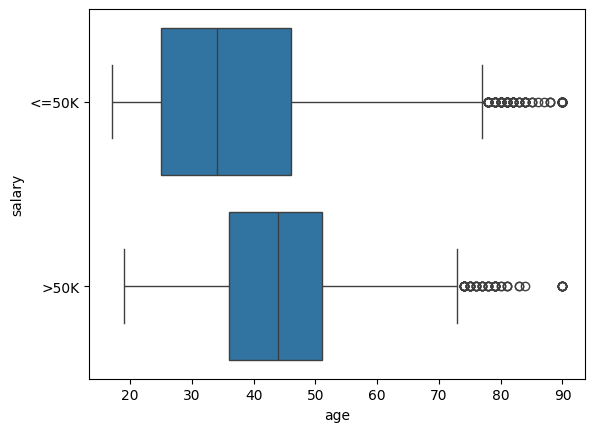

In [18]:
sns.boxplot(x = 'age', y = 'salary', data = salary)
plt.show()

##### 6-2. fnlwgt 변수

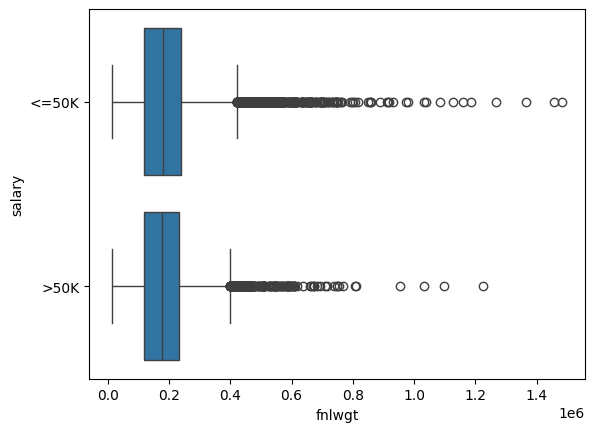

In [19]:
sns.boxplot(x = 'fnlwgt', y = 'salary', data = salary)
plt.show()

##### 6-3. education-num 변수

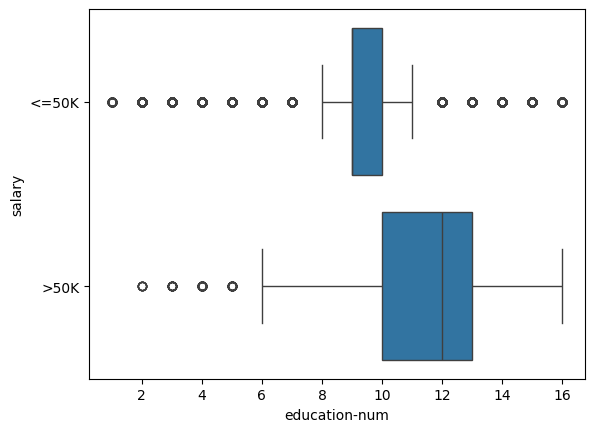

In [20]:
sns.boxplot(x = 'education-num', y = 'salary', data = salary)
plt.show()

##### 6-4. capital-gain 변수

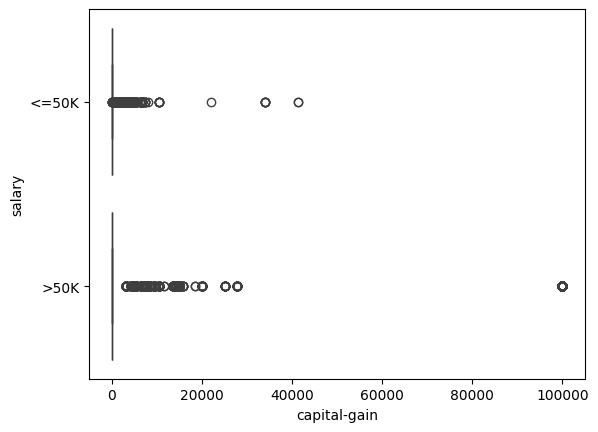

In [21]:
sns.boxplot(x = 'capital-gain', y = 'salary', data = salary)
plt.show()

##### 6-5. capital-loss 변수

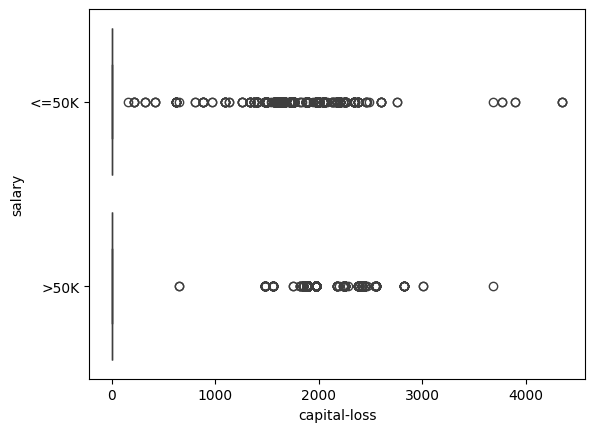

In [22]:
sns.boxplot(x = 'capital-loss', y = 'salary', data = salary)
plt.show()

##### 6-6. hours-per-week 변수

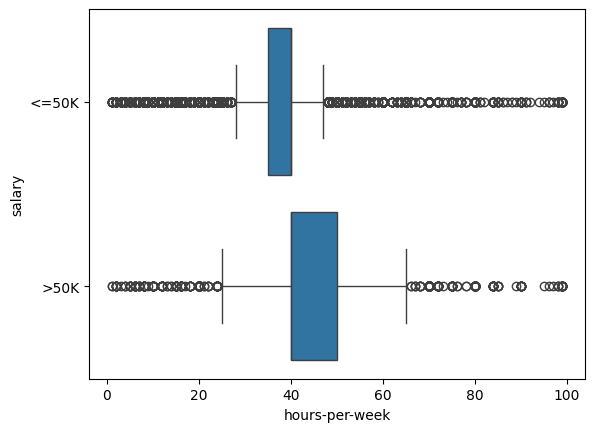

In [23]:
sns.boxplot(x = 'hours-per-week', y = 'salary', data = salary)
plt.show()

>비록 수치형 변수들의 이상치가 많지만 이 데이터들은 실제 값이며  
이상치를 모두 제거한다면 손실이 크기 때문에 데이터 분석의 신뢰성을 잃을 수도 있어  
이상치를 제거하지 않기로 결정

#### 7. 데이터 전처리

##### 7-1. workclass 변수

>workclass 변수의 경우 범주가 너무 많고 Private의 비율이 크기 때문에 Self-emp-not-inc과 Self-emp-inc를 Self-emp(자영업자)로 통합하고 Federal-gov, Local-gov, State-gov를 gov(공무원)로 통합했다. 또한, Never-worked, Without-pay, 결측치를 other(그 외)로 통합하여 4개의 범주로 줄였다.

In [24]:
def integrate_workclass(category):
    if category in ['Self-emp-not-inc', 'Self-emp-inc']:
        return 'Self-emp'
    elif category in ['Federal-gov', 'Local-gov', 'State-gov']:
        return 'gov'
    elif category in ['Never-worked', 'Without-pay', '?']:
        return 'other'
    else:
        return category
    
salary['workclass2'] = salary['workclass'].apply(integrate_workclass)
print(salary['workclass2'].value_counts())

workclass2
Private     22673
gov          4351
Self-emp     3656
other        1857
Name: count, dtype: int64


##### 7-2. native-country 변수

>native-country 변수의 경우 United-States을 제외한 나머지 국가들의 도수가 너무 적어 United-States를 제외한 나머지 변수들과 결측치를 other(그 외)로 통합하여 총 2개의 범주로 줄였다.

In [25]:
def integrate_country(category):
    if category not in 'United-States':
        return 'other'
    else:
        return category

salary['native-country2'] = salary['native-country'].apply(integrate_country)
print(salary['native-country2'].value_counts())

native-country2
United-States    29153
other             3384
Name: count, dtype: int64


##### 7-3. marital-status 변수

>marital-status 변수의 경우 Married-AF-spouse, Married-spouse-absent, Separated, Widowed를 미혼은 아니지만 어떠한 이유에서든 배우자와 동거하지 않은 상태라고 취급하여 other(그 외)로 통합하여 총 4개의 범주로 줄였다.

In [26]:
def integrate_marital(category):
    if category in ['Married-AF-spouse', 'Married-spouse-absent', 'Separated', 'Widowed']:
        return 'other'
    else:
        return category

salary['marital-status2'] = salary['marital-status'].apply(integrate_marital)
print(salary['marital-status2'].value_counts())

marital-status2
Married-civ-spouse    14970
Never-married         10667
Divorced               4441
other                  2459
Name: count, dtype: int64


##### 7-4. capital 변수

>capital 변수의 경우 capital-gain과 capital-loss의 두 변수로 나뉘었지만, capital-gain은 자본을 얻은 양, capital-loss는 자본을 잃은 양을 나타내서 자본을 얻음과 동시에 잃는 것은 불가능하므로 두 변수의 수치가 동시에 0을 초과하는 경우는 없었으며 capital-loss의 값들을 음수로 취한 뒤 capital-gain 변수와 합쳐주어 capital이라는 하나의 변수로 통합시켰다.

In [27]:
# 두 변수의 수치가 동시에 0을 초과하는 경우의 개수
np.sum( (salary['capital-gain'] > 0) * (salary['capital-loss'] > 0) )

0

In [28]:
salary['capital'] = salary['capital-gain'] - salary['capital-loss']

#### 8. 변수 제거

>relationship 변수와 occupation 변수를 제거했다. 왜냐하면, relationship 변수에 속한 범주의 의미를 명확하게 파악하기 어려웠으며 marital-status 변수로도 relationship을 충분히 설명할 수 있다고 생각했기 때문이며 occupation 변수의 경우 범주가 너무 많고 workclass 변수가 상위 개념이라고 생각되어 occupation 변수를 충분히 설명할 수 있다고 생각하여 두 변수를 제거했다.

In [29]:
salary2 = salary.drop(columns = ['relationship', 'occupation'])

print(salary2.columns) # relationship, occupation 변수 제거됨

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'salary', 'workclass2',
       'native-country2', 'marital-status2', 'capital'],
      dtype='object')


#### 9. 인코딩

>salary는 ‘>50K’을 1로, ‘<=50K’을 0으로, sex 변수는 Female을 0, Male을 1로, native-country 변수는 United-States를 0, other를 1로 변환시켰다.

>workclass, marital-status, race 변수는 Label Encoding을 해주었다.

##### 9-1. salary 변수

In [30]:
def salary_encoder(category):
    if category == '<=50K':
        return 0
    else:
        return 1
    
salary2['salary_encoded'] = salary2['salary'].apply(salary_encoder)
print(salary2[['salary', 'salary_encoded']])

      salary  salary_encoded
0      <=50K               0
1      <=50K               0
2      <=50K               0
3      <=50K               0
4      <=50K               0
...      ...             ...
32556  <=50K               0
32557   >50K               1
32558  <=50K               0
32559  <=50K               0
32560   >50K               1

[32537 rows x 2 columns]


##### 9-2. sex 변수

In [31]:
def sex_encoder(category):
    if category == 'Male':
        return 0
    else:
        return 1
    
salary2['sex_encoded'] = salary2['sex'].apply(sex_encoder)
print(salary2[['sex', 'sex_encoded']])

          sex  sex_encoded
0        Male            0
1        Male            0
2        Male            0
3        Male            0
4      Female            1
...       ...          ...
32556  Female            1
32557    Male            0
32558  Female            1
32559    Male            0
32560  Female            1

[32537 rows x 2 columns]


##### 9-3. native-country 변수

In [32]:
def country_encoder(category):
    if category == 'United-States':
        return 0
    else:
        return 1
    
salary2['country_encoded'] = salary2['native-country'].apply(country_encoder)
print(salary2[['native-country', 'country_encoded']])

      native-country  country_encoded
0      United-States                0
1      United-States                0
2      United-States                0
3      United-States                0
4               Cuba                1
...              ...              ...
32556  United-States                0
32557  United-States                0
32558  United-States                0
32559  United-States                0
32560  United-States                0

[32537 rows x 2 columns]


##### 9-4. workclass 변수

In [33]:
label_encoder = LabelEncoder()

salary2['workclass_encoded'] = label_encoder.fit_transform(salary2['workclass2'])
print(salary2[['workclass2', 'workclass_encoded']])

print("Classes:", label_encoder.classes_)
# Private: 0, Self-emp: 1, gov: 2, other: 3

      workclass2  workclass_encoded
0            gov                  2
1       Self-emp                  1
2        Private                  0
3        Private                  0
4        Private                  0
...          ...                ...
32556    Private                  0
32557    Private                  0
32558    Private                  0
32559    Private                  0
32560   Self-emp                  1

[32537 rows x 2 columns]
Classes: ['Private' 'Self-emp' 'gov' 'other']


##### 9-5. marital-status 변수

In [34]:
label_encoder = LabelEncoder()

salary2['marital_encoded'] = label_encoder.fit_transform(salary2['marital-status2'])
print(salary2[['marital-status2', 'marital_encoded']])

print("Classes:", label_encoder.classes_)
# Divorced: 0, Married-civ-spouse: 1, Never-married: 2, other: 3

          marital-status2  marital_encoded
0           Never-married                2
1      Married-civ-spouse                1
2                Divorced                0
3      Married-civ-spouse                1
4      Married-civ-spouse                1
...                   ...              ...
32556  Married-civ-spouse                1
32557  Married-civ-spouse                1
32558               other                3
32559       Never-married                2
32560  Married-civ-spouse                1

[32537 rows x 2 columns]
Classes: ['Divorced' 'Married-civ-spouse' 'Never-married' 'other']


##### 9-6. race 변수

In [35]:
label_encoder = LabelEncoder()

salary2['race_encoded'] = label_encoder.fit_transform(salary2['race'])
print(salary2[['race', 'race_encoded']])

print("Classes:", label_encoder.classes_)
# Amer-Indian-Eskimo: 0, Asian-Pac-Islander: 1, Black: 2, Other: 3, White: 4

        race  race_encoded
0      White             4
1      White             4
2      White             4
3      Black             2
4      Black             2
...      ...           ...
32556  White             4
32557  White             4
32558  White             4
32559  White             4
32560  White             4

[32537 rows x 2 columns]
Classes: ['Amer-Indian-Eskimo' 'Asian-Pac-Islander' 'Black' 'Other' 'White']


#### 10. 최종 데이터프레임

In [36]:
print(salary2.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'salary', 'workclass2',
       'native-country2', 'marital-status2', 'capital', 'salary_encoded',
       'sex_encoded', 'country_encoded', 'workclass_encoded',
       'marital_encoded', 'race_encoded'],
      dtype='object')


In [37]:
salary3 = salary2[['age','workclass_encoded','fnlwgt','education-num','marital_encoded', 'race_encoded',
              'sex_encoded', 'capital', 'hours-per-week', 'country_encoded', 'salary_encoded']]

df = salary3.rename(columns = {'workclass_encoded': 'workclass', 'marital_encoded': 'marital-status',
                     'race_encoded': 'race', 'sex_encoded': 'sex', 'country_encoded': 'native-country',
                     'salary_encoded': 'salary'})

In [38]:
df

,age,workclass,fnlwgt,education-num,marital-status,race,sex,capital,hours-per-week,native-country,salary
0,39,2,77516,13,2,4,0,2174,40,0,0
1,50,1,83311,13,1,4,0,0,13,0,0
2,38,0,215646,9,0,4,0,0,40,0,0
3,53,0,234721,7,1,2,0,0,40,0,0
4,28,0,338409,13,1,2,1,0,40,1,0
...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0,257302,12,1,4,1,0,38,0,0
32557,40,0,154374,9,1,4,0,0,40,0,1
32558,58,0,151910,9,3,4,1,0,40,0,0
32559,22,0,201490,9,2,4,0,0,20,0,0


#### 11. 데이터 분할

>해당 데이터는 종속변수인 salary의 0이 24698개, 1이 7839개로 불균형이 심하다. 데이터 클래스 비율이 너무 차이가 나면(highly-imbalanced data) 단순히 우세한 클래스를 택하는 모형의 정확도가 높아지므로 모형의 성능판별이 어려워진다. 즉, 정확도(accuracy)가 높아도 데이터 개수가 적은 클래스의 재현율(recall-rate)이 급격히 줄어드는 현상이 발생할 수 있다. 따라서 샘플링을 진행하기로 결정

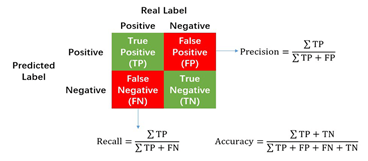

In [39]:
print('salary = 0 :', np.sum(df['salary'] == 0), '개')
print('salary = 1 :', np.sum(df['salary'] == 1), '개')

salary = 0 : 24698 개
salary = 1 : 7839 개


##### 12. 데이터 샘플링 (SMOTE-Tomek sampling)

>샘플링의 종류에는 다수 클래스 데이터에서 일부만 사용하는 Undersampling, 소수 클래스 데이터를 증가시키는 Oversampling, 복합 샘플링이 있다. 본 프로젝트에서는 복합 샘플링을 사용하기로 결정했으며 복합 샘플링 방법중 하나인 SMOTE-Tomek을 사용했다. SMOTE-Tomek은 Oversampling과 Undersampling을 함께 수행하는 방법으로, 이름 그대로 SMOTE로 Oversampling을, Tomek Links로 Undersampling을 수행한다. sampling을 해주기 전에 데이터를 학습용 데이터 셋으로 70%, 나머지 30%는 검증용 데이터 셋으로 나누어 주었다.

In [40]:
# 특성 데이터(x)와 반응변수(y) 설정
x = df.drop(columns = ['salary']) # 반응변수를 제외한 설명변수
y = df['salary'] # 반응변수

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

print(np.shape(y_train)) # train 22775개
print(np.shape(y_test)) # test 9762개

(22775,)
(9762,)


>샘플링은 학습용 데이터 셋에만 해줘야 하므로 학습용 데이터 셋에 SMOTE-Tomek sampling을 해주었다.

In [41]:
# SMOTE-Tomek 샘플링 적용
smt = SMOTETomek(random_state = 42)
x_train_resampled, y_train_resampled = smt.fit_resample(x_train, y_train)

# 샘플링 결과 확인
print(np.shape(y_train_resampled)) # train set이 22775에서 30596으로 증가

(30594,)


>샘플링 후에는 0과 1 모두 15298개로 비율이 맞춰진 것을 확인했다.

In [42]:
print('샘플링 전 0과 1의 개수')
print('0:', np.sum(y_train == 0))
print('1:', np.sum(y_train == 1))
print('샘플링 후 0과 1의 개수')
print('0:', np.sum(y_train_resampled == 0))
print('1:', np.sum(y_train_resampled == 1))

샘플링 전 0과 1의 개수
0: 17293
1: 5482
샘플링 후 0과 1의 개수
0: 15297
1: 15297


#### 13. 데이터 분석

##### 13-1. DecisionTree

>의사결정나무(Decision Tree)는 Machine Learning의 지도 학습(Supervised Learning)에 해당하는 알고리즘으로써 의사결정 규칙을 나무구조로 도표화하여 분류와 예측을 수행한다. 의사결정나무는 직관적으로 이해하기 쉽고 설명할 때 사용하기 용이하다. 하지만, 과적합 및 과소적합이 발생하기 쉬우므로 사용할 때 각별한 주의가 필요하며, 트리의 규모가 클수록 이해하기가 어려워지는 단점이 존재한다. 트리 모델의 경우, 불순도 및 엔트로피 등을 활용하여 분류를 진행하기 때문에 수치형 데이터에 대한 스케일링 과정을 거치지 않아도 된다.

13-1-1. 기본 모델로 학습

In [43]:
# 결정트리 모델 생성
dt = DecisionTreeClassifier(random_state = 42)

# 모델 학습
dt.fit(x_train_resampled, y_train_resampled)

# 예측
y_pred = dt.predict(x_test) # 예측된 y (x_test를 DecisionTree 모델에 넣어서 y값을 예측)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print('정확도:', accuracy) # 실제 데이터를 약 78% 맞춤
print('\n')

# 분류 보고서
print(classification_report(y_test, y_pred))

정확도: 0.7835484531858226


              precision    recall  f1-score   support

           0       0.89      0.82      0.85      7405
           1       0.54      0.68      0.60      2357

    accuracy                           0.78      9762
   macro avg       0.72      0.75      0.73      9762
weighted avg       0.81      0.78      0.79      9762



13-1-2. 하이퍼 파라미터 튜닝으로 학습 (GridSearchCV)

>max_depth: 트리의 최대 깊이 지정  
min_samples_split: 노드를 분할하기 위한 최소 샘플 수 지정  
min_samples_leaf: 리프 노드가 가져야 하는 최소 샘플 수 지정  
max_features: 각 노드에서 분할에 사용할 특성의 최대 수 지정  
criterion: 노드에서의 분할 기준 선택 (기본값은 'gini'이며, 'entropy'도 사용 가능)  

In [44]:
# 탐색할 하이퍼 파라미터 그리드 설정
param_dt = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

> estimator: 검색 대상 모델  
param_grid: 탐색할 하이퍼 파라미터 그리드  
cv: 교차 검증을 위한 폴드(fold)의 수  
n_jobs: 병렬 처리를 위한 작업 수 (-1은 가능한 모든 프로세서 사용)  
scoring: 성능 측정 지표  

In [45]:
# GridSearchCV 객체 생성
dt_grid_search = GridSearchCV(estimator = dt, param_grid = param_dt,
                              cv = 5, n_jobs = -1, scoring = 'accuracy')

# 그리드 탐색 수행
dt_grid_search.fit(x_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [46]:
# 최적의 파라미터와 점수 출력
print('최적의 파라미터')
print(dt_grid_search.best_params_)
print('\n정확도:', dt_grid_search.best_score_) # validation set을 약 83% 맞춤

최적의 파라미터
{'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}

정확도: 0.8312093997543863


In [47]:
# 예측
y_dt_grid_pred = dt_grid_search.predict(x_test)

# 정확도 평가
dt_grid_accuracy = accuracy_score(y_test, y_dt_grid_pred)
print('정확도:', dt_grid_accuracy) # 실제 데이터를 약 77% 맞춤
print('\n')

# 분류 보고서
print(classification_report(y_test, y_dt_grid_pred))

정확도: 0.7724851464863758


              precision    recall  f1-score   support

           0       0.94      0.75      0.83      7405
           1       0.52      0.84      0.64      2357

    accuracy                           0.77      9762
   macro avg       0.73      0.79      0.74      9762
weighted avg       0.83      0.77      0.79      9762



In [48]:
# 결정 트리 모델에서 변수 중요도 추출 (% 단위)
importances = dt_grid_search.best_estimator_.feature_importances_
percent_importances = np.round(importances, 3) * 100

print(percent_importances)

[ 7.4  0.3  0.  17.4 59.9  0.   4.7  6.7  2.8  0.8]


In [49]:
# 변수 이름과 중요도 출력
feature_names = ['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status',
                 'race', 'sex', 'capital', 'hours-per-week', 'native-country']

for feature_name, importance in zip(feature_names, percent_importances):
    print(feature_name, ':', np.round(importance, 1), '%')

age : 7.4 %
workclass : 0.3 %
fnlwgt : 0.0 %
education-num : 17.4 %
marital-status : 59.9 %
race : 0.0 %
sex : 4.7 %
capital : 6.7 %
hours-per-week : 2.8 %
native-country : 0.8 %


| 순위 | 변수명 |
|-------|-------|
| 1  | marital-status  |
| 2  | education-num  |
| 3  | age  |
| 4  | capital  |
| 5  | sex  |
| 6  | hours-per-week  |
| 7  | workclass  |
| 8  | fnlwgt |
| 9  | native-country |
| 10  | race |

##### 13-2. XGBoost

>XGBoost는 Extreme Gradient Boosting의 약자이다. 먼저, Boosting은 여러 개의 약한 Decision Tree를 조합해서 사용하는 Ensemble 기법 중 하나이다. 즉, 약한 예측 모형들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측 모형을 만든다. Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost가 대표적인데 이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost이다. XGBoost의 장점은 GBM 대비 빠른 수행시간이다. 병렬 처리로 학습하고 분류 속도 빠르다. 또한, 자체의 과적합 규제 기능으로 강한 내구성을 지닌다.

13-2-1. 기본 모델로 학습

In [50]:
# 결정트리 모델 생성
xgb = XGBClassifier(random_state = 42)

# 모델 학습
xgb.fit(x_train_resampled, y_train_resampled)

# 예측
y_pred = xgb.predict(x_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print('정확도:', accuracy) # 실제 데이터를 약 82% 맞춤
print('\n')

# 분류 보고서
print(classification_report(y_test, y_pred))

정확도: 0.8229870928088506




              precision    recall  f1-score   support

           0       0.92      0.84      0.88      7405
           1       0.61      0.76      0.67      2357

    accuracy                           0.82      9762
   macro avg       0.76      0.80      0.78      9762
weighted avg       0.84      0.82      0.83      9762



13-2-2. 하이퍼 파라미터 튜닝으로 학습 (GridSearchCV)

>n_estimators: 트리의 개수 지정 (기본값 100)  
learning_rate: 학습률 (학습률이 작을수록 모델이 더 안정적으로 수렴하고 더 많은 트리가 필요)  
max_depth: 트리의 최대 깊이 지정   
sub_sample: 각 트리를 학습하는 데 사용되는 훈련 데이터의 일부분의 비율  
min_child_weight: 각 내부 노드에서의 최소 가중치 합을 나타내는 파라미터  

In [51]:
# 탐색할 하이퍼 파라미터 그리드 설정
param_xgb = {
    'n_estimators' : [50, 100, 150],
    'learning_rate' : [0.001, 0.01, 0.1],
    'max_depth' : [3, 5, 7],
    'subsample' : [0.5, 0.7, 0.9],
    'min_child_weight' : [1, 3, 5]
}

In [52]:
# GridSearchCV 객체 생성
xgb_grid_search = GridSearchCV(estimator = xgb, param_grid = param_xgb,
                               cv = 5, n_jobs = -1, scoring = 'accuracy')

# 그리드 탐색 수행
xgb_grid_search.fit(x_train_resampled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.5, 0.7, 0.9]},
             scoring='accuracy')

In [53]:
# 최적의 파라미터와 점수 출력
print('최적의 파라미터')
print(xgb_grid_search.best_params_)
print(xgb_grid_search.best_score_)

최적의 파라미터
{'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.7}
0.8732767262094642
